Model Building

In [1]:
!pip install prophet

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pickle


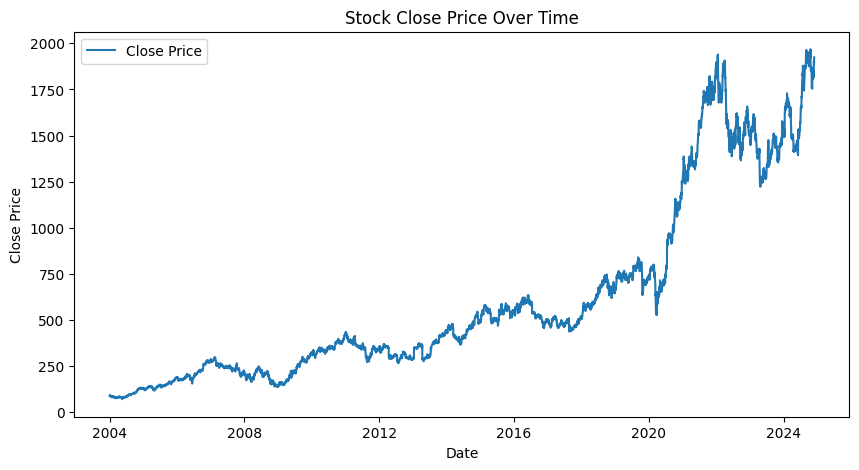

In [3]:
# Load the dataset
data = pd.read_csv('Infosys_Stock_Data.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Use the 'Close' column for forecasting
time_series = data['Close']

# Visualize the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series, label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [4]:
# Split data into training and testing sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]


ARIMA MODEL

In [5]:
# Train ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [6]:
# Forecast
arima_forecast = arima_result.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [7]:
# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

ARIMA RMSE: 552.3598317425018


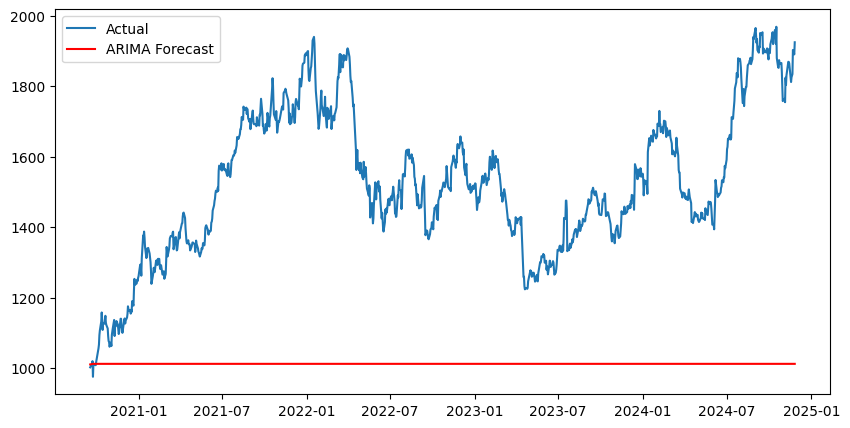

In [8]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

SARIMA MODEL

In [9]:
# Train SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
# Evaluate SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f'SARIMA RMSE: {sarima_rmse}')

SARIMA RMSE: 441.23192549539857


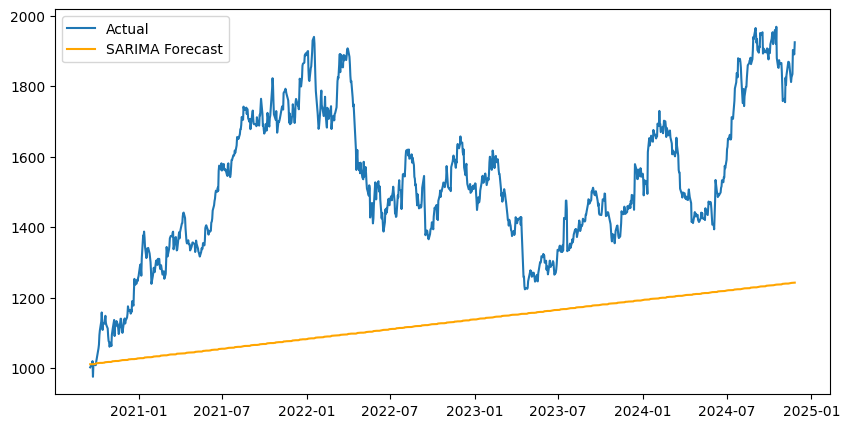

In [12]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(test, label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.legend()
plt.show()

PROPHET MODEL

In [13]:
# Prepare data for Prophet
prophet_data = data.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [14]:
# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data[:train_size])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw04pjuor/73aa5f5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw04pjuor/9q33ufoa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58210', 'data', 'file=/tmp/tmpw04pjuor/73aa5f5a.json', 'init=/tmp/tmpw04pjuor/9q33ufoa.json', 'output', 'file=/tmp/tmpw04pjuor/prophet_model6g6yfgvm/prophet_model-20241221030850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:08:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
# Forecast
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

In [16]:
# Evaluate Prophet
prophet_rmse = np.sqrt(mean_squared_error(test, forecast['yhat'][-len(test):]))
print(f'Prophet RMSE: {prophet_rmse}')

Prophet RMSE: 572.3762069887296


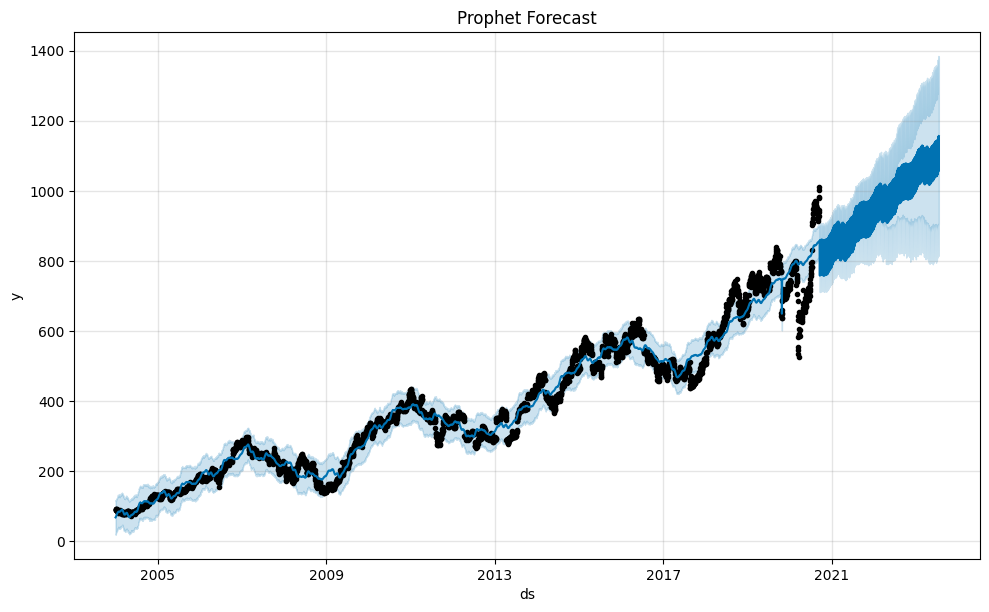

In [17]:
# Plot
prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

LSTM MODEL

In [18]:
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.values.reshape(-1, 1))

In [19]:
# Create training and testing data
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

In [20]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [21]:
# Build LSTM model

# Initialize the LSTM model
model = Sequential()

# Add LSTM layers with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add Dense layer
model.add(Dense(units=1))  # Predict the next day's price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0050 - val_loss: 9.1101e-04
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 3.9612e-04 - val_loss: 0.0038
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 3.5495e-04 - val_loss: 0.0011
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 3.2602e-04 - val_loss: 0.0032
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2.9172e-04 - val_loss: 0.0021
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 3.1483e-04 - val_loss: 0.0015
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 2.6375e-04 - val_loss: 6.3888e-04
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 2.2237e-04 - val_loss: 0.0019
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 2.0396e-04 - val_loss: 7.1259e-04
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.9390e-04 - val_loss: 6.2870e-04
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 1.8714e-04 

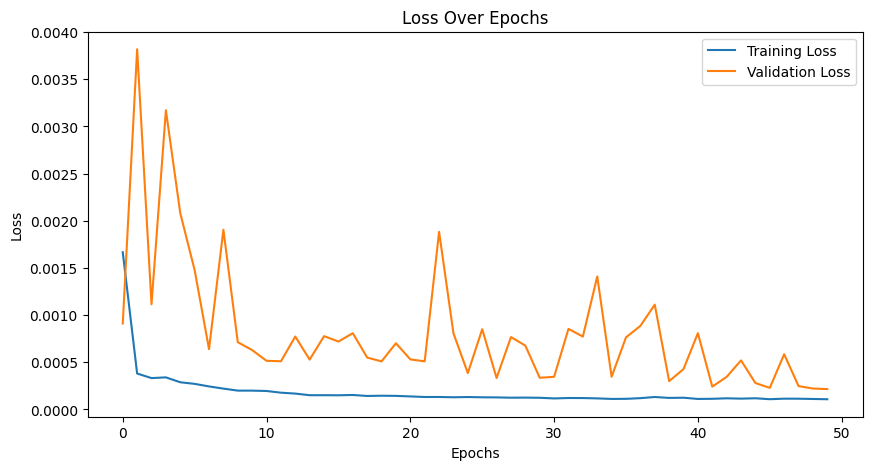

In [23]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Forecasting
X_test_unscaled = scaler.inverse_transform(X_test.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Rescale to original values
real_prices = scaler.inverse_transform(y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [25]:
# Evaluate the model
lstm_rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f"LSTM : {lstm_rmse}")

LSTM : 27.835446069199502


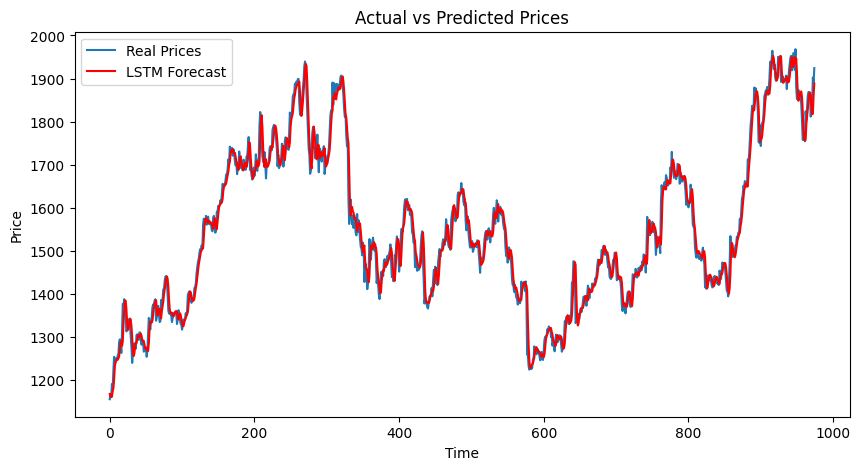

In [26]:
# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='LSTM Forecast', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# Compareing RMSE's for best model
models_rmse = {
    'ARIMA': arima_rmse,
    'SARIMA': sarima_rmse,
    'Prophet': prophet_rmse,
    'LSTM': lstm_rmse
}
best_model = min(models_rmse, key=models_rmse.get)
print(f'The best model is: {best_model} with RMSE = {models_rmse[best_model]:.2f}')

The best model is: LSTM with RMSE = 27.84


In [29]:
# Save the LSTM model and scaler
model.save('lstm_model.h5')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    print("Model and Scaler saved successfully")


Model and Scaler saved successfully
